In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [7]:
mac_base_path = "/Users/joonwonlee/Documents/A.I._Machine_Learning_Projects/trav"
vehicles = pd.read_csv( Path(mac_base_path) /"vehicles.csv")
policies = pd.read_csv( Path(mac_base_path) / "policies.csv")
drivers = pd.read_csv( Path(mac_base_path) / "drivers.csv")

In [8]:
vehicles.head()

,Unnamed: 0,policy_id,car_no,ownership_type,color,age,make_model
0,6,policy_74571,1,leased,other,4.0,BMW : R1200CL
1,7,policy_74571,2,owned,blue,3.0,ACURA : TL
2,15,policy_1998,1,owned,gray,7.0,BMW : 750LI
3,29,policy_28085,1,owned,gray,4.0,MERCEDES-BENZ : G55 AMG
4,34,policy_64282,1,owned,black,4.0,BMW : 550I GT


### Missing data

For categorical variables, I plan to use mode to fill missings but for continuous variables, I want to see the actual distributions of variables to choose between median and mean to fill missings. 

For skewed data, median can better represent central tendency. 

In [10]:
def mode_encode(df:pd.DataFrame, col_name:str):
    tmp = df[col_name].mode()
    df[col_name] = df[col_name].fillna(tmp[0])
    
def mean_encode(df:pd.DataFrame, col_name:str):
    tmp = df[col_name].mean()
    df[col_name] = df[col_name].fillna(tmp)

def median_encode(df:pd.DataFrame, col_name:str):
    tmp = df[col_name].median()
    df[col_name] = df[col_name].fillna(tmp)

Let me show some skewed variables below.

In [11]:
# quoted_amt has a form of "$4,500". Make it float.
policies['quoted_amt'] = policies['quoted_amt'].str[1:]
policies['quoted_amt'] = policies['quoted_amt'].astype(str).str.replace(',','').astype(float)
policies['state_safty'] =  policies['state_id'].apply( lambda x: 1 if x in ['CT','MN' ,'WI'] else (3 if x in ['NY','AL','GA','NJ'] else 2))

print(f'Skewness of quoted_amt: {policies['quoted_amt'].skew()}')
print(f'Skewness of vehicle age: {vehicles['age'].skew() }')
print(f'Skewness of driver age: {drivers['age'].skew() }')
print(f'Skewness of drivers safty rating: {drivers['safty_rating'].skew() }')

Skewness of quoted_amt: 3.619782946241044
Skewness of vehicle age: 0.45082232812486467
Skewness of driver age: 0.2728148452253024
Skewness of drivers safty rating: -0.9619020823577018


### Outliars, Scaling, skewness

Without much feature engineering, I compared basic CNN, LightGBM, and other models to evaluate their performance. I decided to use LightGBM, as it seemed the most promising based on its results.

Since scaling, outliers, and the skewness of variables are less critical for tree-based models, I chose to focus on other aspects instead.

### Feature Engineering

### 1. Caveat: DO NOT CREATE NEW VARIABLES BEFORE MODELING ON THE GIVEN DATASET.
Reason: If a newly created variable is noisy and becomes influential in a tree model, it can be misleading and mask other important features.

Diagnostic: When optimizing hyperparameters, if the optimized max_depth is too small (like 4 or 5) relative to the number of features in the dataset, you want to be careful because the model may stop growing deeper trees because it doesn't find additional splits helpful and if the splits rely on wrong variable, the model can be misleading.  Removing such misleading factors can significantly improve the model's performance and allow other variables to become influential again.

Example: I created a new feature, make_risk, which served as an indicator for risky car brands. This feature was quite subjective and turned out to be misleading. After removing it, the model's performance dramatically improved, and the discount variable, whose influence was previously masked, became important again.

In [12]:
policies['state_safty'] =  policies['state_id'].apply( lambda x: 1 if x in ['CT','MN' ,'WI'] else (3 if x in ['NY','AL','GA','NJ'] else 2))
policies['discount'] = policies['discount'].apply(lambda x: 1 if x=='Yes' else 0 )
policies['Home_policy_ind'] = policies['Home_policy_ind'].apply(lambda x: 1 if x=='Y' else 0 )
policies['Cov_package_type'] = policies['Cov_package_type'].apply(lambda x: 1 if x=='Low' else (2 if x=='Medium' else 3) )
policies['primary_parking'] = policies['primary_parking'].apply(lambda x: 1 if x=='street' else (3 if x=='parking garage' or x=='home/driveway' else 2) )

policies['quote_year'] = pd.to_datetime(policies['Quote_dt']).dt.year
policies['quote_month'] = pd.to_datetime(policies['Quote_dt']).dt.month
policies = policies.drop(columns=['Quote_dt','Unnamed: 0'])

drivers.rename(columns={'age':'dr_age'}, inplace=True)
drivers=pd.get_dummies(drivers,columns=["gender"])
living_status_dict = {'dependent': 1,'rent': 2,'own': 3}  # scaling less impact on tree model
drivers['living_status']= drivers['living_status'].map(living_status_dict)
drivers['dr_age'] = np.sqrt(drivers['dr_age']  )
drivers1 = drivers.groupby('policy_id')[['dr_age','safty_rating']].mean()
# For car insurance, it does not make sense to aggreate driver's age over each household or policy_id because 
# when I looked at the age, there were significant number of people with age over 80 90 or even 100, and I don't think they will drive 
# by themselves, if this was a life insurance it is matter but this is a car insurance 
# I may transform age data by square root transformation and this will compress the influence of older ages
drivers = drivers.drop(columns=['Unnamed: 0'])
drivers = drivers.groupby('policy_id').mean()

owner_dict = {'leased': 1,'loaned': 2,'owned': 3} 
vehicles['ownership_type']= vehicles['ownership_type'].map(owner_dict)
vehicles = vehicles.drop(columns=['Unnamed: 0','color' ,'make_model'])
vehicles.rename(columns={'age':'car_age'}, inplace=True)


### Fill missings

In [13]:
median_encode(vehicles, 'car_age')
mode_encode(drivers, 'safty_rating')
mean_encode(policies,'quoted_amt') # no median 
mode_encode(policies,'zip')
mean_encode(policies,'credit_score')
mode_encode(policies,'Prior_carrier_grp')
mode_encode(policies,'Cov_package_type')
mode_encode(policies,'CAT_zone')
mode_encode(policies,'convert_ind')
mode_encode(policies,'Agent_cd')
mode_encode(drivers,'high_education_ind')
mode_encode(drivers,'living_status')

### Merge three data sets: drivers, policies, policies

In [14]:
df1 = pd.merge(policies, vehicles, on = 'policy_id', how='inner')
df = pd.merge(df1, drivers, on = 'policy_id', how='inner')
df = df[df['split']=='Train']

### High Cardinality Categorical Variables

Variables like 'zip', 'county_name', 'policy_id' have high cardinality and simple one-hot encoding may not be helpful. 

Aggregation: The process of summarizing data by applying a function (sum, mean, count) to group-level subsets. 

We can simply remove them or REPLACE WITH AN AGGREGATED TARGET VALUE (e.g., average conversion rate for each county).

It turns out that conversion rates for each county, prior insurer, and catastrophe level are influential features in a tree-based model.

county_conversion_rate = df.groupby('county_name', observed=True)['convert_ind'].mean()
df['county_conversion_rate'] = df['county_name'].map(county_conversion_rate)

cat_conversion_rate = df.groupby('CAT_zone', observed=True)['convert_ind'].mean()
df['CAT_zone_conversion_rate'] = df['CAT_zone'].map(cat_conversion_rate)

Prior_conversion_rate = df.groupby('Prior_carrier_grp', observed=True)['convert_ind'].mean()
df['Prior_conversion_rate'] = df['Prior_carrier_grp'].map(Prior_conversion_rate)


In [15]:
for x in df.columns:
    print(f'{x}: {df[x].nunique()}')

discount: 2
Home_policy_ind: 2
zip: 1168
state_id: 8
county_name: 112
Agent_cd: 1628
quoted_amt: 12622
Prior_carrier_grp: 9
credit_score: 418
Cov_package_type: 3
CAT_zone: 5
policy_id: 36871
number_drivers: 6
num_loaned_veh: 4
num_owned_veh: 3
num_leased_veh: 3
total_number_veh: 8
convert_ind: 2
split: 1
primary_parking: 3
state_safty: 3
quote_year: 4
quote_month: 12
car_no: 8
ownership_type: 3
car_age: 17
living_status: 12
dr_age: 9640
safty_rating: 581
high_education_ind: 11
gender_F: 13
gender_M: 13


### Tips for other feature engineering

Sometimes you have to go back and forth to create better features because model output themselves can give you an idea. 

Below are some ideas worth trying:

1. Discretize continuous variables such as credit_score. 

df['credit_score_bin'] = pd.cut(df['credit_score'], bins=[0, 600, 700, 800, 900], labels=['low', 'medium', 'high', 'excellent']).astype('category')

2. Try different combination of interaction terms.

df['driver_vehicle_ratio'] = df['number_drivers'] / df['total_number_veh']   
df['quoted_amt_discount'] = (df['discount']+1)* df['quoted_amt']

3. How long has it passed since quoted data.   

df['month_sin'] = np.sin(2 * np.pi * df['quote_month'] / 12)   
df['month_cos'] = np.cos(2 * np.pi * df['quote_month'] / 12)   
df['time_since_quote'] = 2024 - df['quote_year'] + (12 - df    ['quote_month']) / 12    


In [16]:
df1 = pd.merge(policies, vehicles, on = 'policy_id', how='inner')
df = pd.merge(df1, drivers, on = 'policy_id', how='inner')
df = df[df['split']=='Train']
df = df.drop(columns=['policy_id','split', 'zip'])

categorical_columns = ['state_id', 'county_name', 'Prior_carrier_grp']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# df['total_vehicles'] = df['num_owned_veh'] + df['num_leased_veh'] + df['num_loaned_veh']

df = df.drop(columns=['num_owned_veh','num_leased_veh','num_loaned_veh'])

df['month_sin'] = np.sin(2 * np.pi * df['quote_month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['quote_month'] / 12)
# df= df.drop(columns=['quote_month'])  0.0002 we need this
df['quote_year_cat'] = df['quote_year'].astype('category')

df['credit_score_bin'] = pd.cut(df['credit_score'], bins=[0, 600, 700, 800, 900], labels=['low', 'medium', 'high', 'excellent']).astype('category')

df = df.drop(columns=['credit_score'])  # better than 0 600 800 900 or 0 500 600 700 800 900

df['driver_vehicle_ratio'] = df['number_drivers'] / df['total_number_veh']

df = df.drop(columns=['state_id'])

county_conversion_rate = df.groupby('county_name', observed=True)['convert_ind'].mean()
df['county_conversion_rate'] = df['county_name'].map(county_conversion_rate)

cat_conversion_rate = df.groupby('CAT_zone', observed=True)['convert_ind'].mean()
df['CAT_zone_conversion_rate'] = df['CAT_zone'].map(cat_conversion_rate)

Prior_conversion_rate = df.groupby('Prior_carrier_grp', observed=True)['convert_ind'].mean()
df['Prior_conversion_rate'] = df['Prior_carrier_grp'].map(Prior_conversion_rate)

# df= df.drop(columns=['state_safty']) this is helpful

df['time_since_quote'] = 2024 - df['quote_year'] + (12 - df['quote_month']) / 12

df= df.drop(columns=['Agent_cd','county_name']) # 0.6947 to 0.7041 

df['quoted_amt_discount'] = (df['discount']+1)* df['quoted_amt']

df.to_csv("C:\\Users\\joonw\\trav\\trav_dataset3.csv", index=False)


#### Starting Point for Feature Engineering: Correlation Matrix

I think the correlation matrix is not always reliable as it only shows linear relationships, but it can still provide useful insights.

It seems that 'convert_ind' is correlated with 'quoted_amount', 'discount', and some other variables. Investigating these variables first is better than exploring without any direction. However, note that there are other variables, like 'safety_rating', which have a weak linear correlation with the response but may still be important features.

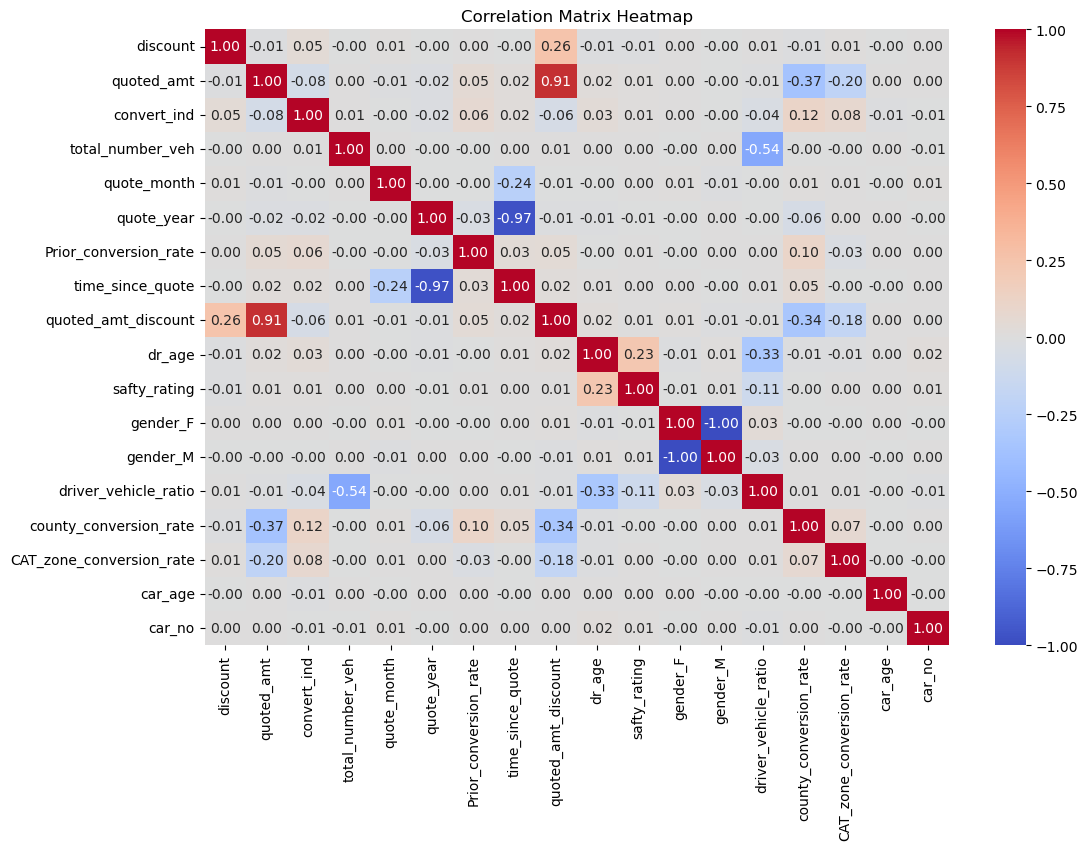

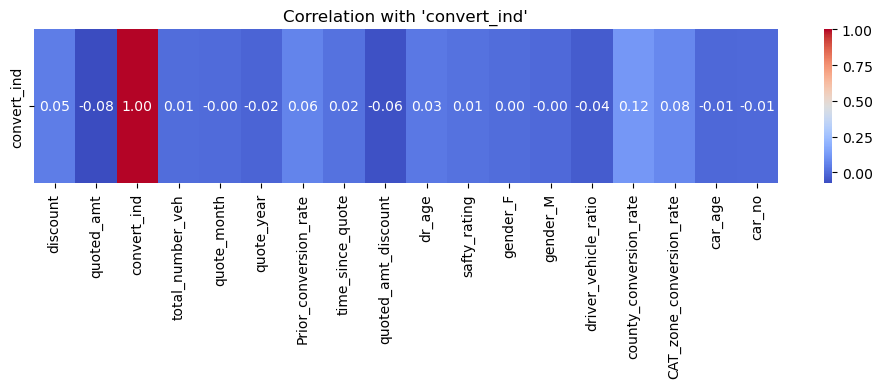

In [18]:
columns1 = ['discount','quoted_amt','convert_ind','total_number_veh','quote_month','quote_year','Prior_conversion_rate','time_since_quote','quoted_amt_discount','dr_age']
columns2 = ['safty_rating','gender_F','gender_M','driver_vehicle_ratio','county_conversion_rate','CAT_zone_conversion_rate','car_age','car_no']
columns = columns1+columns2
df2 = df[columns]

correlation_matrix = df2.corr()
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

# Assuming correlation_matrix is already computed
# Select the row corresponding to 'convert_ind'
row_of_interest = correlation_matrix.loc[['convert_ind']]

# Plot the heatmap for the specific row
plt.figure(figsize=(12, 2))  # Adjust the height to make it look like a single row
sns.heatmap(row_of_interest, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation with 'convert_ind'")
plt.show()

### Not helpful feature engineering:  

df['has_discount'] = (df['discount'] > 0).astype(int)

agent_freq = df['Agent_cd'].value_counts()
df['agent_freq'] = df['Agent_cd'].map(agent_freq)

df['log_quoted_amt'] = np.log1p(df['quoted_amt'])

First two digits of policy_id or zip code

df['policy_id_1'] = df['policy_id'].astype(str).str[8:8+1].astype('category')
df['zip_1'] = df['zip'].astype(str).str[:1].astype('category')